In [52]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt


In [53]:
# Read in file
column = ['objID','z','uMAG','rMAG','u-r','SVMPython']
df = pd.read_csv("/Users/abbystokes/Documents/GitHub/AST5731_PROJ3/dataset.tsv", sep='\t', header=None, names = column)
df.size


1896186

In [54]:
# Selecting only 0.05 < z < 0.08 and spiral (SVMPython = 1), randomly sample 10,000 galaxies
df = df[(df['z']<0.08) & (df['z']>0.05) & (df['SVMPython']==1) & (df['uMAG']<50)]
df.size
df = df.sample(n=10000)


In [55]:
max(df['uMAG'])


-10.06799

Text(0.5, 0, 'uMAG')

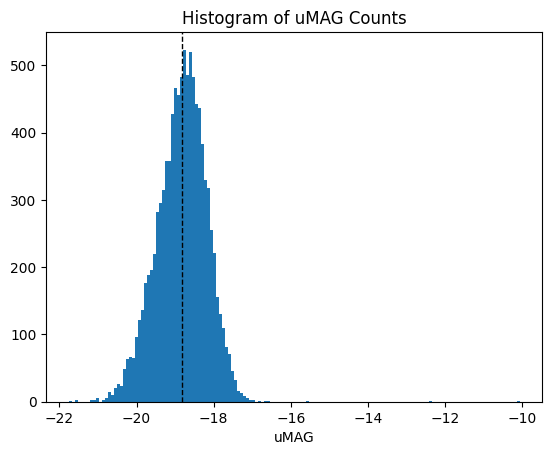

In [56]:
plt.hist(df['uMAG'], bins=150)
plt.axvline(df['uMAG'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.title("Histogram of uMAG Counts")
plt.xlabel("uMAG")

Text(0.5, 0, 'rMAG')

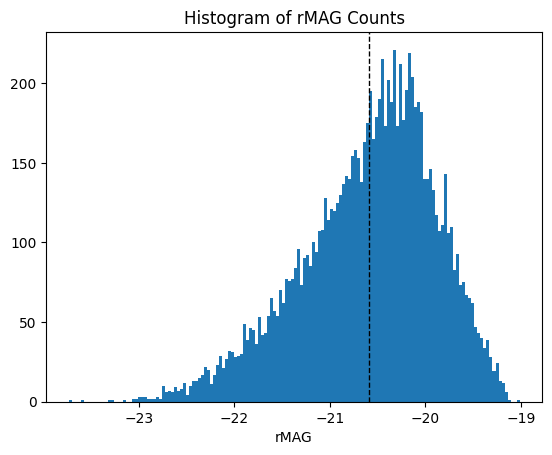

In [57]:
plt.hist(df['rMAG'], bins=150)
plt.axvline(df['rMAG'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.title("Histogram of rMAG Counts")
plt.xlabel("rMAG")

Text(0.5, 1.0, 'r vs. u - r (uncensored)')

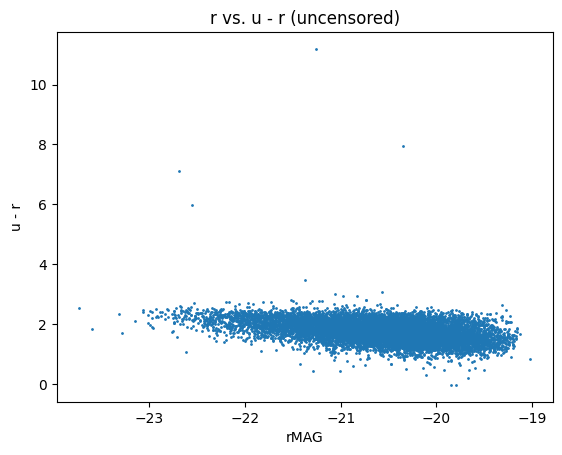

In [58]:
plt.scatter(df['rMAG'], df['u-r'],s=1)
plt.xlabel("rMAG")
plt.ylabel('u - r')
plt.title("r vs. u - r (uncensored)")

In [59]:
# Adding censored data column for uMAG > -18.5
df['censored_uMAG'] = df['uMAG']
df.loc[df['censored_uMAG'] > -17,'censored_uMAG'] = -17

Text(0.5, 1.0, 'r vs. u - r (censored)')

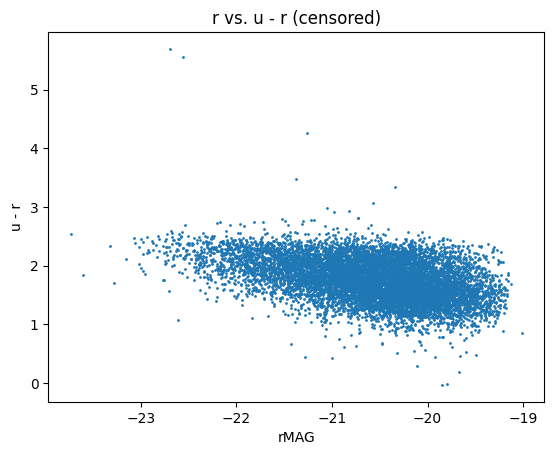

In [60]:
df['censored_u-r'] = df['censored_uMAG'] - df['rMAG']
plt.scatter(df['rMAG'], df['censored_u-r'], s=1)
plt.xlabel("rMAG")
plt.ylabel('u - r')
plt.title("r vs. u - r (censored)")

Text(0.5, 1.0, 'uMAG vs. rMAG')

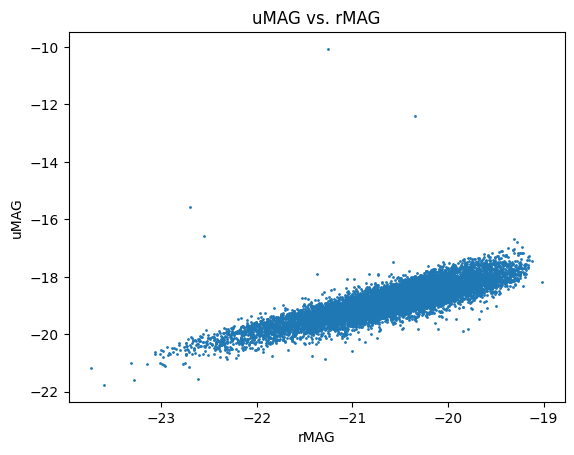

In [61]:
plt.scatter(df['rMAG'], df['uMAG'], s=1)
plt.xlabel('rMAG')
plt.ylabel('uMAG')
plt.title('uMAG vs. rMAG')

Text(0.5, 1.0, 'uMAG vs. rMAG (censored)')

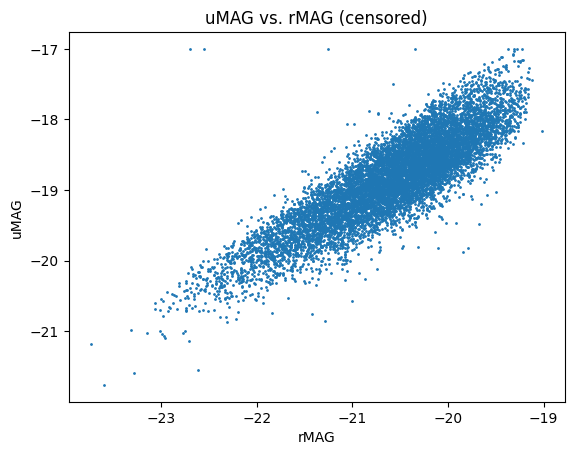

In [62]:
plt.scatter(df['rMAG'], df['censored_uMAG'], s=1)
plt.xlabel('rMAG')
plt.ylabel('uMAG')
plt.title('uMAG vs. rMAG (censored)')